In [1]:
%matplotlib notebook
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from os import path
import numpy as np
import cv2 as cv
import trimesh
import os

# Our local modules
import src.calibrate as clb
import src.render as render
import src.transform as tf
import src.util as util

# Overview

Here we generate a 3D render based on the calibrated camera intrinsics and extrinsics.

# Check that we're in the correct folder

For the code in this notebook to work correctly, the Jupyter server must be started from the `endoscope-calibration` folder. Then you put all of your data in the `./endoscope-calibration/data/`. 

In [2]:
# Check that we're in the right directory
base_dir_name = 'endoscope-calibration'
cwd = os.getcwd()
if not cwd.endswith(base_dir_name):
    print('[WARNING] Your base directory is not \'{}\' - are you running '
          'Jupyter in the correct server?'.format(base_dir_name))
    
data_dir = path.join(cwd, 'data')

# Load endoscope marker meshes from the phantom CT scan

In [3]:
endo_phantom_dir = path.join(data_dir, 'endo_phantom')
endo_phantom_image_file = path.join(endo_phantom_dir, 'image.png')
endo_phantom_model_file = path.join(endo_phantom_dir, 'mesh2_phantom.stl')
endo_phantom_markers_file = path.join(endo_phantom_dir, 'mesh1_endoscope_markers.stl')
endo_phantom_markers_joint = trimesh.load(endo_phantom_markers_file)

phantom_centroids = util.extract_marker_mesh_centroids(endo_phantom_markers_joint)
phantom_points_3d = np.array(phantom_centroids).T

# Load our camera intrinsics/extrinsics estimates

In [4]:
intrinsics_file = path.join(data_dir, 'refined_intrinsics.json')
cam_matrix, dist_coeffs, width, height = util.load_intrinsics(intrinsics_file)
extrinsics_file = path.join(data_dir, 'extrinsics.json')
T_rigid_to_cam, endoscope_markers = util.load_extrinsics(extrinsics_file)

new_cam_matrix, roi = cv.getOptimalNewCameraMatrix(cam_matrix, dist_coeffs,
                                                   (width, height), 1, (width, height))

# Find transform from world to our calibration reference frame

In [5]:
T_world_to_rigid = clb.calc_rigid_body_transform(phantom_points_3d, endoscope_markers)

# Find transform from world to camera frame and visualise it

<IPython.core.display.Javascript object>


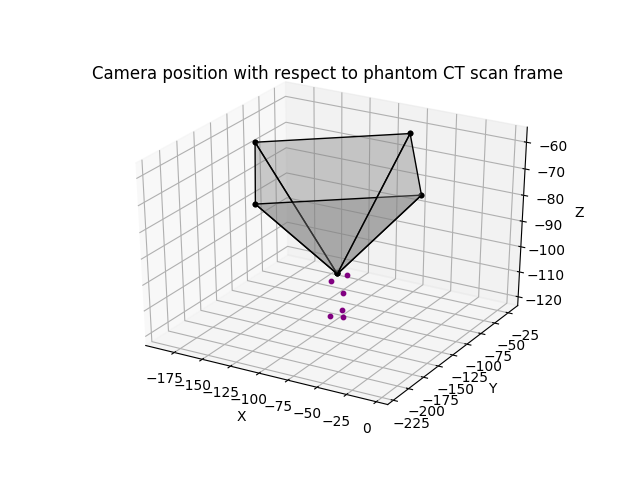

In [6]:
T_world_to_cam = T_rigid_to_cam @ T_world_to_rigid
T_cam_to_world = np.linalg.inv(T_world_to_cam)

_, ax = util.prepare_3d_plot(title='Camera position with respect to phantom CT scan frame')
util.draw_3d_points(ax, phantom_points_3d, colour='purple')
util.draw_3d_camera(ax, width, height, new_cam_matrix, T_cam_to_world, z=40)

# Generate 3D render

In [8]:
rendered_image = render.generate_render(
    width=width, height=height,
    T_cam_to_world=T_cam_to_world, cam_matrix=new_cam_matrix,
    phantom_model_path=endo_phantom_model_file,
    endoscope_markers_path=endo_phantom_markers_file
)
rendered_image = cv.cvtColor(rendered_image, cv.COLOR_BGR2RGB)

print('Render shape:', rendered_image.shape)

Render shape: (1024, 1280, 3)


# Overlay the 3D render over original image

<IPython.core.display.Javascript object>


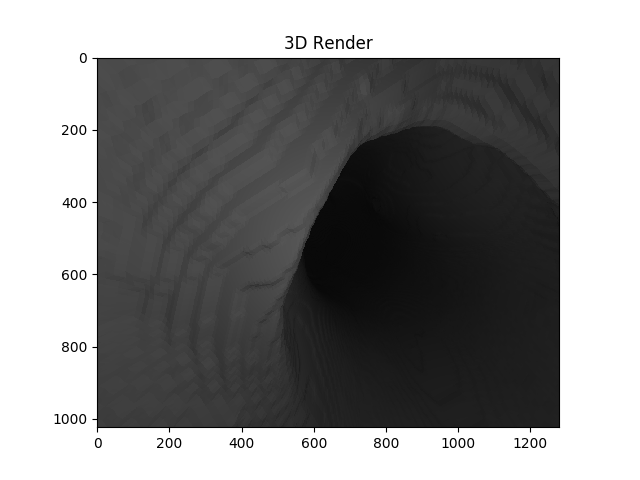

<IPython.core.display.Javascript object>


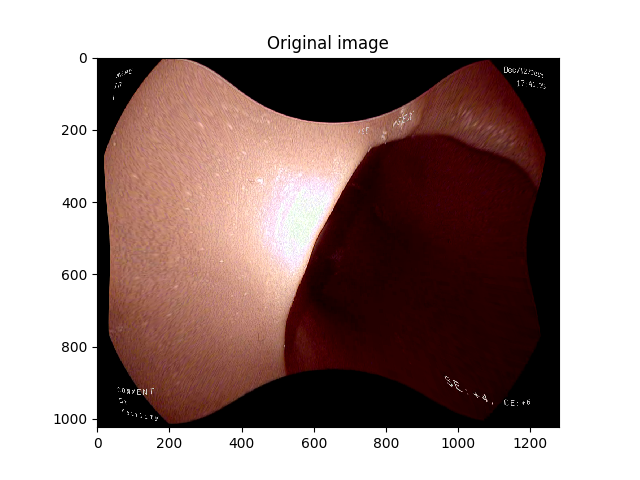

<IPython.core.display.Javascript object>


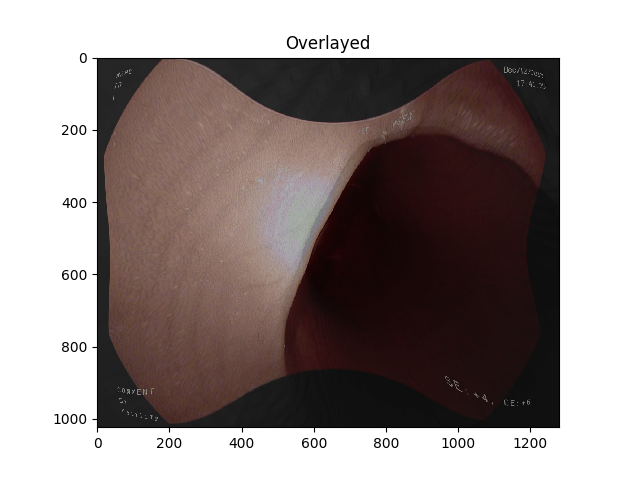

In [9]:
actual_image = cv.imread(endo_phantom_image_file)
actual_image = cv.cvtColor(actual_image, cv.COLOR_BGR2RGB)
overlayed = cv.addWeighted(actual_image, 0.5, rendered_image, 0.5, 0.0)

titles = ['3D Render', 'Original image', 'Overlayed']
images= [rendered_image, actual_image, overlayed]
for i in range(len(images)):
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.set_title(titles[i])
    ax.imshow(images[i])